# Matplotlib and Wandb

In [3]:
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

os.chdir('/opt/ml/P-Stage/1-STAGE/')

from config import get_args
from prepare import get_dataloader

In [4]:
weight_path = "/opt/ml/weights"

age_path = os.path.join(weight_path, "age.pt")
mask_path = os.path.join(weight_path, "mask.pt")
gender_path = os.path.join(weight_path, "gender.pt")

age_model = torch.load(age_path)
mask_model = torch.load(mask_path)
gender_model = torch.load(gender_path)

In [5]:
args = get_args()
args.test = True

In [6]:
train_dataloader, test_dataloader = get_dataloader(args)

In [7]:
images, labels = next(iter(train_dataloader))
images, labels = images.cuda(), labels.cuda()

In [8]:
outputs = age_model(images)

In [7]:
# images, outputs, labels
# 하나의 모델, Train 할 때
# 여러개의 모델, Predict 할 때

In [9]:
import matplotlib.pyplot as plt

In [10]:
images_len = len(images)

In [11]:
col_num = int(len(images) ** 0.5)
col_num

8

In [12]:
outputs = F.softmax(outputs, dim=1)
outputs

tensor([[7.8941e-01, 2.1021e-01, 3.8154e-04],
        [9.4094e-02, 8.9747e-01, 8.4387e-03],
        [1.5506e-01, 8.2529e-01, 1.9655e-02],
        [8.4376e-01, 1.5612e-01, 1.1495e-04],
        [3.3687e-01, 6.5739e-01, 5.7467e-03],
        [3.6302e-03, 9.3460e-01, 6.1768e-02],
        [7.5981e-02, 8.7078e-01, 5.3236e-02],
        [2.7142e-01, 7.2807e-01, 5.0753e-04],
        [6.9189e-02, 9.0051e-01, 3.0305e-02],
        [2.0129e-02, 4.2824e-01, 5.5163e-01],
        [9.3773e-03, 9.8332e-01, 7.3023e-03],
        [1.7255e-03, 8.5003e-01, 1.4824e-01],
        [4.1773e-03, 6.8160e-01, 3.1422e-01],
        [3.8547e-02, 7.6414e-01, 1.9732e-01],
        [1.5345e-01, 7.2355e-01, 1.2300e-01],
        [8.0753e-01, 1.9219e-01, 2.7975e-04],
        [2.8285e-03, 8.8849e-01, 1.0868e-01],
        [6.0495e-01, 3.7834e-01, 1.6708e-02],
        [2.4247e-02, 9.4583e-01, 2.9924e-02],
        [2.4628e-03, 8.8846e-01, 1.0908e-01],
        [8.6878e-03, 5.9003e-01, 4.0128e-01],
        [1.2589e-02, 4.5922e-01, 5

In [13]:
import numpy as np

mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

In [14]:
cpu_images = images.cpu().numpy()
cpu_images = (cpu_images * std) + mean
cpu_images = cpu_images.transpose(0, 2, 3, 1)

In [15]:
outputs[0], labels[0]

(tensor([7.8941e-01, 2.1021e-01, 3.8154e-04], device='cuda:0',
        grad_fn=<SelectBackward>),
 tensor(0, device='cuda:0'))

In [16]:
predict_label = torch.argmax(outputs[0]).item()
real_label = labels[0].item()
predict_label, real_label

(0, 0)

In [21]:
from prepare import get_classes

args.train_key = "age"
age_classes = get_classes(args)

In [22]:
age_classes

['age < 30', '30 <= age < 60', '60 <= age']

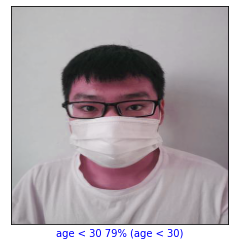

In [23]:
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(cpu_images[0])

if predict_label == real_label:
    color = 'blue'
else:
    color = 'red'
    
plt.xlabel("{} {:2.0f}% ({})".format(age_classes[predict_label],
                            100*outputs[0].detach().cpu().numpy()[predict_label],
                            age_classes[real_label]),
                            color=color)

plt.show()

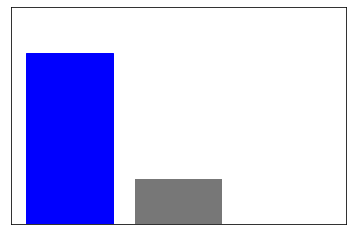

In [24]:
plt.grid(False)
plt.xticks([])
plt.yticks([])

thisplot = plt.bar(range(3), outputs[0].detach().cpu().numpy(), color="#777777")
plt.ylim([0, 1])

thisplot[predict_label].set_color('red')
thisplot[real_label].set_color('blue')

In [34]:
import numpy as np

import torch.nn.functional as F
import matplotlib.pyplot as plt

from prepare import get_classes


def plot_image(ax, image, output, pred_label, true_label, classes):
    ax.grid(False)
    
    color = "red"
    if pred_label == true_label:
        color = "blue"

    ax.imshow(image)
    ax.set_xlabel(
        "{} {:2.0f}% ({})".format(
            classes[pred_label], 100 * output[pred_label], classes[true_label]
        ),
        color=color,
    )


def plot_value_array(ax, output, pred_label, true_label, classes):
    ax.grid(False)
    ax.set_ylim([0, 1])

    thisplot = ax.bar(range(len(classes)), output, color="#777777")

    thisplot[pred_label].set_color("red")
    thisplot[true_label].set_color("blue")

    
def plots_result(args, images, outputs, labels):
    """ all inputs are tensor """

    MEAN = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
    STD = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

    outputs = F.softmax(outputs, dim=1)

    # to numpy
    images = images.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # image preprocessing
    images = np.clip((images * STD) + MEAN, 0, 1)  # 0 ~ 1
    images = images.transpose(0, 2, 3, 1)  # (batch, width, height, channel)

    classes = get_classes(args)

    num_rows = num_cols = int(len(images) ** 0.5)
    num_images = num_rows * num_cols
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols * 2, figsize=(36, 18))
    plt.setp(axes, xticks=[], yticks=[])
    
    for idx in range(num_images):
        image, output, label = images[idx], outputs[idx], labels[idx]

        num_row = idx // num_rows
        num_col = idx % num_cols

        pred_label = np.argmax(output)
        true_label = label
        
        plot_image(
            axes[num_row][num_col * 2], image, output, pred_label, true_label, classes
        )
        
        plot_value_array(axes[num_row][num_col * 2 + 1], output, pred_label, true_label, classes)

    return fig

In [35]:
images, labels = next(iter(train_dataloader))
images, labels = images.cuda(), labels.cuda()
outputs = age_model(images)

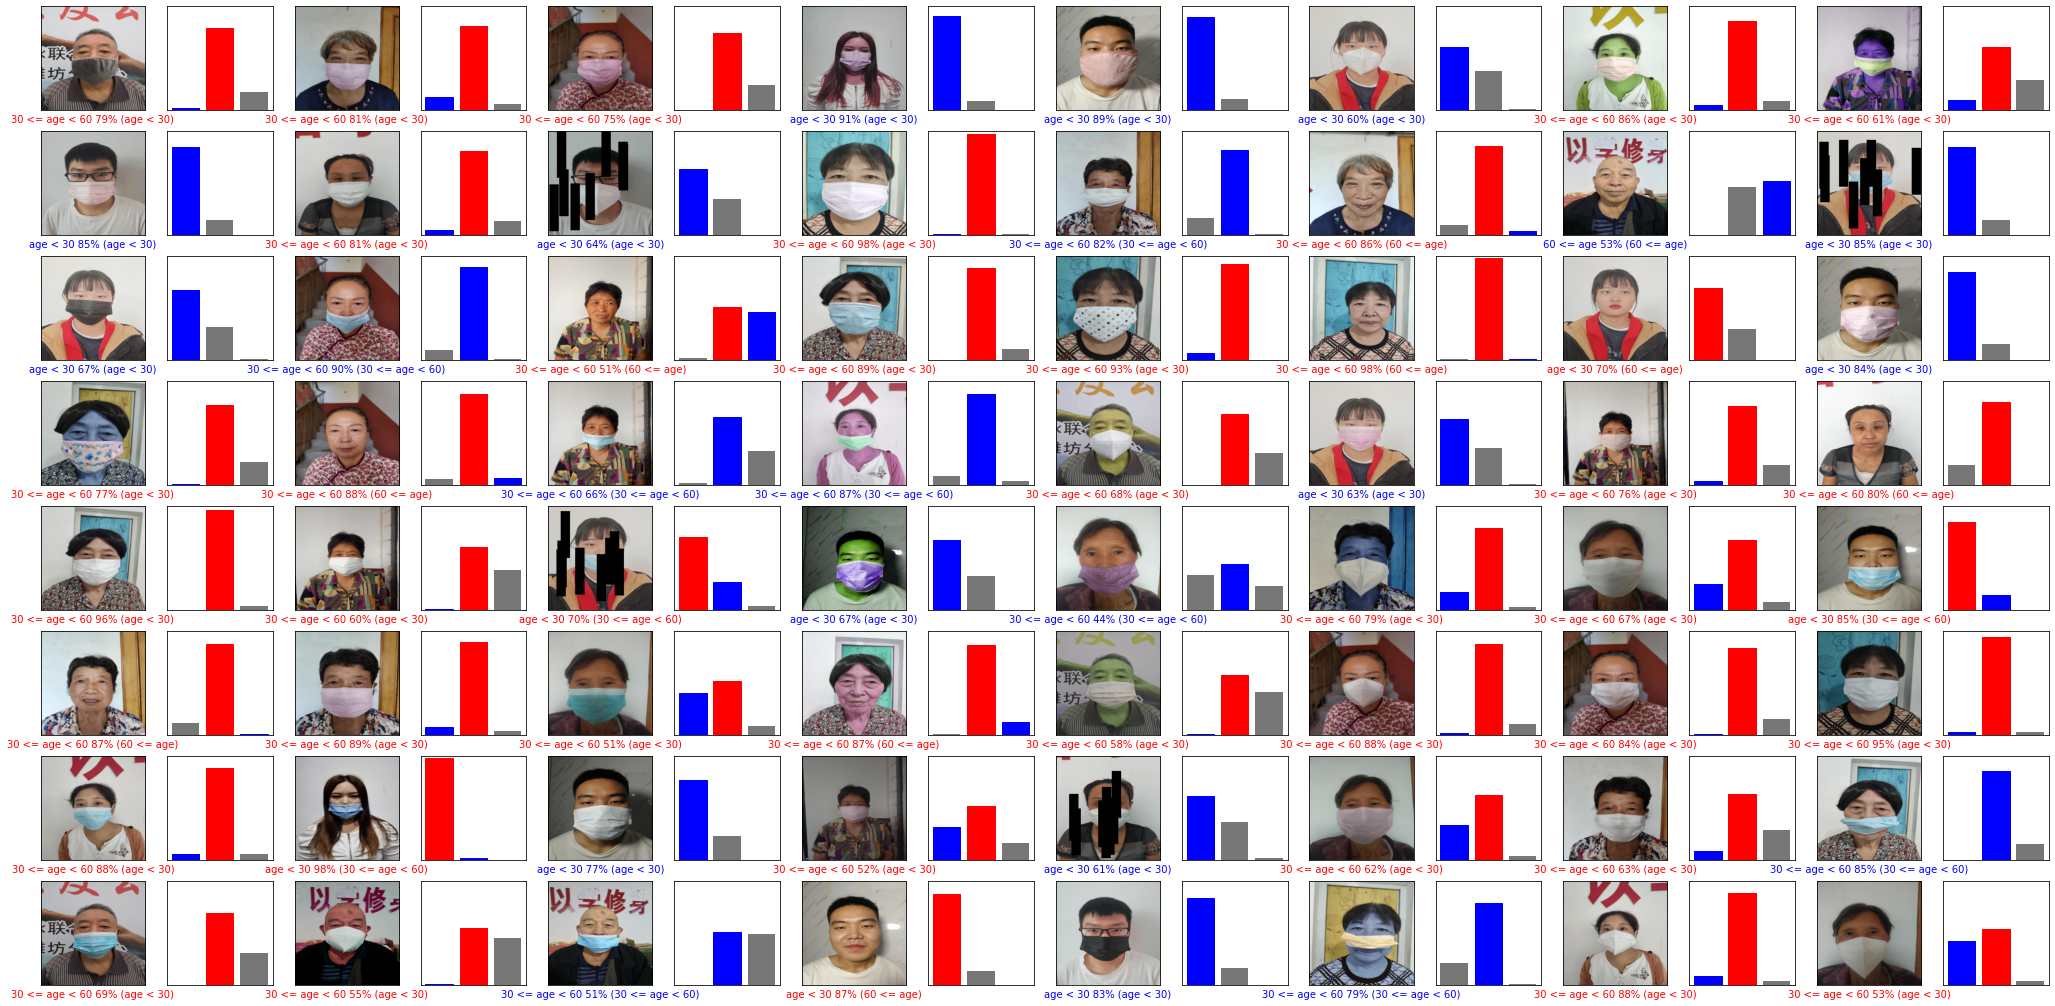

In [36]:
fig1 = plots_result(args, images, outputs, labels)

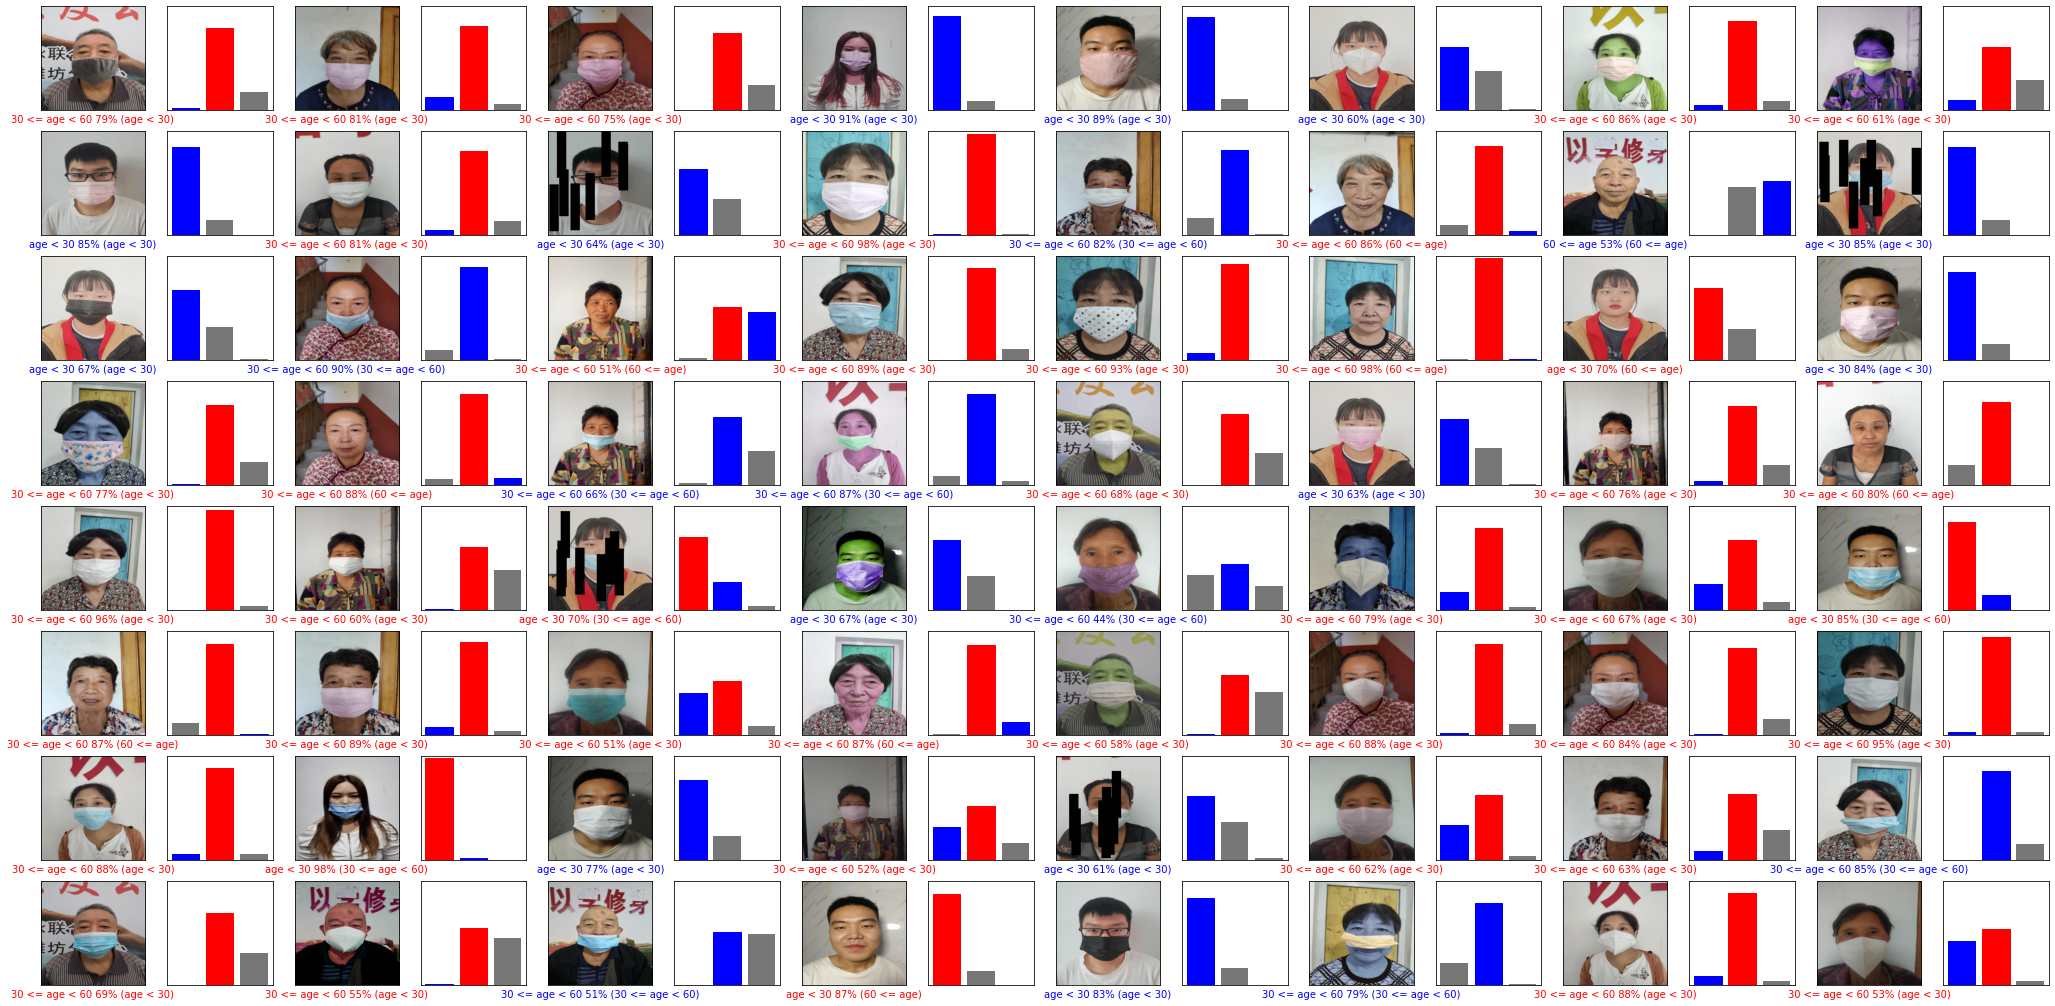

In [37]:
fig2 = plots_result(args, images, outputs, labels)

## Check Focal Loss

In [159]:
images, labels = next(iter(train_dataloader))
images, labels = images.cuda(), labels.cuda()
outputs = age_model(images)

In [166]:
import torchvision
from torchvision.ops.focal_loss import sigmoid_focal_loss

In [173]:
nn.CrossEntropyLoss()(outputs, labels)

tensor(1.7623, device='cuda:0', grad_fn=<NllLossBackward>)

In [170]:
sigmoid_focal_loss(outputs, labels)

ValueError: Target size (torch.Size([64])) must be the same as input size (torch.Size([64, 3]))

In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
 
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [195]:
f = FocalLoss(gamma=0)

In [196]:
f(outputs, labels)

tensor(1.7623, device='cuda:0', grad_fn=<MeanBackward0>)

In [198]:
f(outputs, outputs)

RuntimeError: gather_out_cuda(): Expected dtype int64 for index

## KLDivLoss 적용 하는 법

In [216]:
nn.KLDivLoss('mean')(F.softmax(outputs, dim=1).log(), F.softmax(outputs, dim=1))

tensor(0., device='cuda:0', grad_fn=<KlDivBackward>)

In [218]:
nn.KLDivLoss('mean')(F.log_softmax(outputs, dim=1), F.softmax(outputs, dim=1))

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`


tensor(-1.7583e-09, device='cuda:0', grad_fn=<KlDivBackward>)

In [209]:
nn.KLDivLoss()(torch.tensor([[0.4, 0.6]]), torch.tensor([[0.6, 0.4]]))

tensor(-0.5765)

In [208]:
nn.KLDivLoss()(torch.tensor([0.6, 0.4]), torch.tensor([0.4, 0.6]))

tensor(-0.5765)

In [211]:
import torch
a2 = torch.FloatTensor([0.3, 0.6, 0.1])
a1 = torch.FloatTensor([0.4, 0.5, 0.1])
c1 = torch.nn.KLDivLoss()(a1.log(),a2)
print(c1)

tensor(0.0077)
